## 실습 과정.
    1. 데이터를 다운로드하여 Colab에 로드.
    2. 필요한 라이브러리를 import
    3. 코드는 위에서부터 아래로 순서대로 실행하여 이미지 분류 과제를 수행.

## 데이터 소개
    - 이번 주제는 Intel image classification dataset을 사용.
    - Intel image classification dataset은 buildings, forest, mountains, glacier, sea, street 6개의 class로 구성.
    - 파일은 하나의 압축파일로 구성되며 압축파일은 다음과 같이 구성.
    - 모든 데이터는 각 class 이름에 해당되는 directory 아래에 있음.    

- 원본 데이터 출처: https://www.kaggle.com/puneet6060/intel-image-classification

## 문제 소개
    - 이번 실습에서는 image classification model(이미지 분류 모델)을 만들어서 학습하고, 성능을 향상하기 위한 방법들을 찾아서 학습해보도록 한다.

## 최종 목표    
    - pre-trained CNN 활용 방법 이해
    - CNN의 성능을 올리기 위한 다양한 방법 습득

In [ ]:
## Step 1. 데이터 다운로드 및 전처리

## library를 import 하는 과정.
## 추가로 필요한 library가 있으면 추가로 import 해도 좋다.
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
## Hyper-Parameter 설정
# image resolution
RES = 224
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001

### 문제 1. 데이터 불러오기

    - data는 아래 url(google drive)에 저장되어 있다.(tar 파일)
    - gdown library를 이용하여 data를 다운받고, 현재 directory에 tar파일 압축을 풀어준다.

In [ ]:
data_url = 'https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ'

In [ ]:
## data download 받기(gdown.download 사용)
gdown.download(data_url, 'intel_image_classification.tar', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDyPlWP3AczXJbBmmjSGuAJXY7R_IjeJ
To: /content/intel_image_classification.tar
100%|██████████| 388M/388M [00:02<00:00, 153MB/s]


'intel_image_classification.tar'

In [ ]:
!tar -xf ./intel_image_classification.tar

- 아래와 같이 train dataset은 train_dir, validation dataset은 val_dir로 경로를 설정하게 된다.

In [ ]:
data_dir = "."
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
val_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

In [ ]:
!ls $train_dir

buildings  forest  glacier  mountain  sea  street


### 문제 2. dataset 만들기
    - keras.preprocessing.image_dataset_from_directory를 이용하여 training용 dataset(이름: train_ds), validation용 dataset(이름: val_ds)를 만든다.
    - 위 hyperparameter를 참조하여 image_size와 batch_size를 설정한다.
    - training data는 shuffle=True로 설정한다.

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES, RES),
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    batch_size=N_BATCH
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


### 문제 3. training data, validation data 갯수 확인
    - 위 dataset 생성시에 나오는 log에서 training data와 validation data의 갯수를 확인하여, 각각 N_TRAIN, N_VAL 변수에 저장한다.

In [ ]:
N_TRAIN = 14034
N_VAL = 3000

### 문제 4. class list 만들기
    - class 이름을 저장하고 있는 list를 생성하도록 한다.

 data 공급 속도를 빠르게 하기 위하여 dataset에 prefetch를 적용한다.

In [ ]:
# classes = ['buildings', 'forest', 'mountains', 'glacier', 'sea', 'street']
classes = train_ds.class_names
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

## Dataset 확인
- train_ds에서 batch를 5개 읽어와서 각 batch의 첫번째 image를 화면에 출력한다.
    - 위 class list에서 image에 대한 label을 찾아서 title로 넣는다.

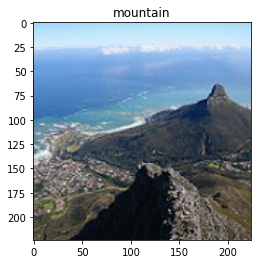

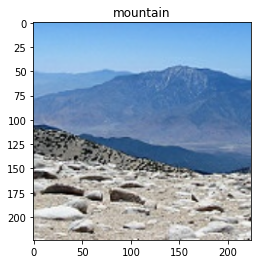

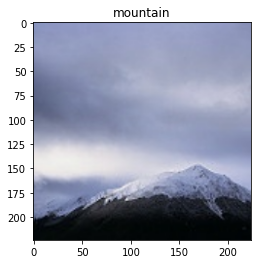

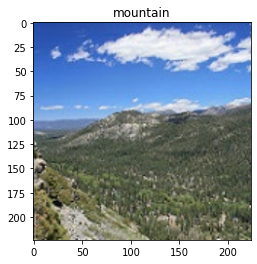

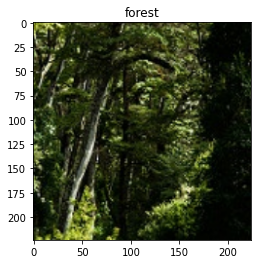

In [ ]:
for images, labels in train_ds.take(5):
  plt.imshow(images[0].numpy().astype('uint8'))
  plt.title(classes[labels[0].numpy()])
  plt.show()  

## Step 2. Pretrained MobileNetV3로 Training 하기
이번 Step에서는 MobileNetV3를 이용하여 image classification을 학습해보는 시간을 가지도록 한다. 

- pretrained MobileNetV3는 tensorflow.keras.applications에서 기본으로 제공한다.
    - 아래와 같이 pretrained MobileNetV3 model을 다운받는 과정을 거치도록 한다.

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

6709248/6698480 [==============================] - 0s 0us/step


In [ ]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

### Intel image classification을 위한 MobileNetV3 model 만들기    
    - functional API를 활용하여 6개의 class를 classification하는 model을 만들어본다.
    - fully connected layer는 1개만 추가하고, batchnorm을 사용한다.
    - MobileNetV3에 data가 들어가기 전에 preprocess_input을 적용하여 input data가 preprocessing 될 수 있도록 한다.

In [ ]:
def create_model():
  inputs = keras.Input(shape=(RES, RES, 3))
  x = preprocess_input(inputs)
  x = mobilenetv3(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(N_CLASS)(x)
  x = BatchNormalization()(x)
  outpus = Softmax()(x)
  model = keras.Model(inputs=inputs, outputs=outpus)
  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                             

  ### 이제 학습하기
    - SGD를 사용하여 model을 학습합니다.(총 epoch수는 N_EPOCH으로 설정)
    - learning rate은 위에서 정한 hyperparameter(LR)을 사용한다.
    - loss는 cross entropy를 사용한다.

In [ ]:
model.compile(keras.optimizers.SGD(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

Epoch 1/50
220/220 [==============================] - 38s 116ms/step - loss: 2.0599 - accuracy: 0.1954 - val_loss: 2.0005 - val_accuracy: 0.1930
Epoch 2/50
220/220 [==============================] - 24s 108ms/step - loss: 1.7828 - accuracy: 0.2889 - val_loss: 1.8274 - val_accuracy: 0.2737
Epoch 3/50
220/220 [==============================] - 24s 108ms/step - loss: 1.5711 - accuracy: 0.3759 - val_loss: 1.6139 - val_accuracy: 0.3660
Epoch 4/50
220/220 [==============================] - 25s 114ms/step - loss: 1.4158 - accuracy: 0.4463 - val_loss: 1.4381 - val_accuracy: 0.4390
Epoch 5/50
220/220 [==============================] - 25s 115ms/step - loss: 1.3064 - accuracy: 0.5041 - val_loss: 1.3074 - val_accuracy: 0.4903
Epoch 6/50
220/220 [==============================] - 25s 111ms/step - loss: 1.2234 - accuracy: 0.5465 - val_loss: 1.2120 - val_accuracy: 0.5457
Epoch 7/50
220/220 [==============================] - 25s 112ms/step - loss: 1.1600 - accuracy: 0.5822 - val_loss: 1.1430 - val_ac

### Optimizer 변경하고 예제를 돌려보기.
    - 같은 model에서 optimizer 함수만 Adam으로 변경하여 학습해본다.

In [ ]:
model = create_model()

In [ ]:
model.compile(keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

## Model의 성능을 올려보기

이번 Step에서는 다양한 방법을 사용하여 MobileNetV3의 성능을 올려보도록 하는 과정을 거치도록 한다.

9. Data augmentation 사용하기.
- training data에 data augmentation을 적용해본다.
- dataset을 만들 때 training data를 256x256으로 resize한다.
- augmentation function을 만들고, 224x224로 random crop한다.
- horizontal flip도 random으로 적용합니다.
- augmentation을 하였으므로 training epoch을 100으로 키운다.
- optimizer와 다른 hyperparameter는 수정하지 않고 training한다.

In [ ]:
RES_BEF = 256
N_EPOCH = 100

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    batch_size=N_BATCH
)

In [ ]:
def aug(image, label):
  image = tf.image.random_crop(image, [RES, RES, 3])
  image = tf.image.random_flip_left_right(image)
  return image, label

In [ ]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [ ]:
model = create_model()

In [ ]:
model.compile(keras.optimizers.Adam(learning_rate=LR), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

entation 방법 중 하나인 cutmix를 구현해본다.
    - 논문은 https://arxiv.org/abs/1905.04899 에서 확인이 가능,
    - 알고리즘에 대한 간략한 설명은 맨 첫부분에 이론강의로 제공되니, 강의를 시청하고 문제를 푸는 것도 좋다.

    - cutmix를 위해서는 사전에 label이 one-hot encoding되어 있어야 하므로, dataset을 수정하여 label이 one-hot이 되도록 한다.

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

In [ ]:
for images, labels in train_ds.take(1):  
  print(labels[0].numpy())
for images, labels in val_ds.take(1):  
  print(labels[0].numpy())

In [ ]:
def cutmix(images, labels):
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    W = RES
    H = RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    label1 = labels[i]
    label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)
  new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

## cutmix 적용 및 확인
    - 작성한 cutmix 알고리즘을 train_ds에 적용하고, 문제 5에서와 같이 확인해본다.
    - 앞에서 적용했던 random crop과 random flip도 함께 적용한다.

In [ ]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [ ]:
for images, labels in train_ds.take(5):
  plt.imshow(images[0].numpy().astype('uint8'))
  print(labels[0].numpy())
  plt.show()  

### 13. cutmix 적용하여 training
    - model을 새로 생성하고 학습하여 결과를 확인해본다.
    - 다른 hyperparameter는 이전과 동일하게 하여 결과를 비교해본다.

In [ ]:
model = create_model()

In [ ]:
model.compile(keras.optimizers.Adam(LR), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

### 14. Bigger resolution
    - input image resolution을 320x320으로 키워본다.
    - random crop을 적용하기 전 resolution은 330x330으로 설정한다.
    - resolution에 맞게 train_ds와 val_ds를 다시 생성하고, data augmentation을 동일하게 적용한다.


In [ ]:
## Hyper-Parameter 설정
# image resolution
RES_BEF = 330
RES = 320
# class 수 
N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 100
# learning rate
LR = 0.0001

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=(RES_BEF, RES_BEF),
    label_mode='categorical',
    batch_size=N_BATCH
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=(RES, RES),
    label_mode='categorical',
    batch_size=N_BATCH
)

In [ ]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

### 15. Learning rate warmup + cosine decay 구현
    - custom learning rate scheduler를 만들어서 warm up과 cosine anealing을 구현해본다.
    - max_lr, warmup_steps, decay_steps 세가지 항목을 입력을 받을 수 있도록 한다.
    - max_lr은 최대 learning rate, warmup_steps는 warm up이 끝나는 step 수, decay steps는 cosine decay가 끝나는 step 수를 의미.
    - keras.optimizers.schedules.LearningRateSchedule를 상속하여 subclass로 만든다.
    - 자세한 사항은 아래 링크들을 참고하시면 됩니다.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule

https://www.tensorflow.org/tutorials/text/transformer

In [ ]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, max_lr, warmup_steps, decay_steps):
    super(CustomSchedule, self).__init__()
    self.max_lr = max_lr
    self.warmup_steps = warmup_steps
    self.decay_steps = decay_steps

  def __call__(self, step):
    lr = tf.cond(step < self.warmup_steps, 
                 lambda: self.max_lr / self.warmup_steps * step, 
                 lambda: 0.5 * (1+tf.math.cos(math.pi * (step - self.warmup_steps) / self.decay_steps))*self.max_lr)
    return lr

### 16. Learning rate scheduling visualization
    - 위에서 작성한 learning rate scheduling class가 제대로 동작하는지 적당한 값을 넣고 graph를 그려서 확인해보자.

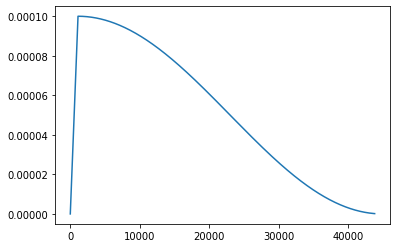

In [ ]:
steps_per_epoch = N_TRAIN // N_BATCH
lr_schedule = CustomSchedule(LR, 5*steps_per_epoch, 200*steps_per_epoch)
lr = []
for step in range(steps_per_epoch*200):
  lr.append(lr_schedule(step))
step_list = list(np.arange(steps_per_epoch*200)+1)
plt.plot(step_list, lr)
plt.show()

In [ ]:
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

## Label smoothing 적용하여 학습을 해보기
    - 위에서 새로 적용한 모든 것들(resolution, epoch 수, learning rate scheduling)을 다 반영하고, label smoothing까지 적용하여 학습해본다.
    - max_lr은 LR로, warmup_steps는 3 epoch에 해당하는 step수, decay_steps는 N_EPOCH에 해당하는 step수만큼으로 설정.
    - label smoothing 값은 0.1로 설정한다.

In [ ]:
model = create_model()

In [ ]:
lr_schedule = CustomSchedule(LR, 3*steps_per_epoch, N_EPOCH*steps_per_epoch)
model.compile(keras.optimizers.Adam(lr_schedule), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)

### Learning rate decay(계단식) 적용하여 학습.
    - 계단식으로 learning rate decay를 적용.
    - 매 30 epoch마다 1/10로 learning rate을 decay 시키도록 하여 학습.
    - 구현은 keras.optimizers.schedules.ExponentialDecay API를 활용.
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [ ]:
model = create_model()

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)

In [ ]:
model.compile(keras.optimizers.Adam(lr_schedule), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

In [ ]:
model.fit(train_ds, epochs=N_EPOCH, validation_data=val_ds)